In [1]:
import os, sys

import numpy as np

import torch
from torch import nn
from torchvision import transforms

import matplotlib.pyplot as plt

sys.path.append('../..')

from lib.datasets import (get_train_test_img_ids_split, get_kfolds, actual_lbl_nums,
                          patches_rgb_mean_av1, patches_rgb_std_av1, patches_clean90_csv_path)
from lib.dataloaders import PatchesDataset
from lib.augmentations import augment_empty, augment_v1
from lib.models.unetv1 import get_model
from lib.utils import get_pretrained_model

train_img_ids, test_img_ids = get_train_test_img_ids_split()

In [2]:
test_img_ids[:4]

['e8baa3bb9dcfb9cef5ca599d62bb8046',
 '9b2948ff81b64677a1a152a1532c1a50',
 '5b003d43ec0ce5979062442486f84cf7',
 '375b2c9501320b35ceb638a3274812aa']

In [3]:
device = torch.device('cuda:1')

In [4]:
model = get_pretrained_model(get_model, {
    'classes': actual_lbl_nums,                     
    'backbone': 'seresnet18_mini',
    'decoder_channels': (64, 64, 64, 32, 16),
}, "../../experiments_results/pretrain/clean_patches90_small_se_resnet18_v1/version_0/checkpoints/last.ckpt", 
                             device, encoder_only=False)

In [5]:
batch_size = 64
num_workers = 6

In [6]:
train_loader = torch.utils.data.DataLoader(
    PatchesDataset(train_img_ids, csv_path=patches_clean90_csv_path,
                   transform=augment_v1,
                   scale=0.5,
                   load_masks=True),
    batch_size=batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=False,
)

val_loader = torch.utils.data.DataLoader(
    PatchesDataset(test_img_ids, csv_path=patches_clean90_csv_path,
                   transform=augment_empty,
                   scale=0.5,
                   load_masks=True),
    batch_size=batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=False,
)

In [7]:
model.eval();

with torch.no_grad():
    for imgs, masks, labels, providers, isup_grades, g_scores in val_loader:
        n_imgs = (imgs - patches_rgb_mean_av1) / patches_rgb_std_av1
        
        n_imgs = n_imgs.float().to(device)
        
        o_masks, o_labels, o_imgs = model(n_imgs)
        # o_masks = model(n_imgs)[0]
        
        break

In [8]:
o_masks.shape, o_imgs.shape

(torch.Size([64, 9, 256, 256]), torch.Size([64, 3, 256, 256]))

In [9]:
n = 0

In [292]:
n += 1

In [293]:
providers[n].item()

0

In [294]:
#for t, p in zip(labels[n], torch.cat([o_labels[n, :6].softmax(dim=-1), o_labels[n, -3:].softmax(dim=-1)])):
#    print(f"{t.item():.2f} {p.item():.2f}")

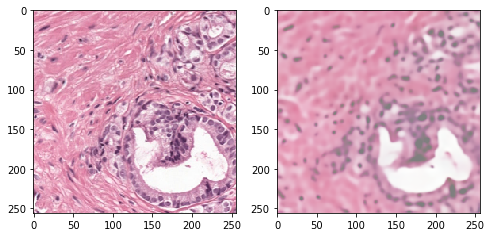

In [295]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(imgs[n].cpu().transpose(0, -1));
axs[1].imshow(o_imgs[n].cpu().transpose(0, -1));

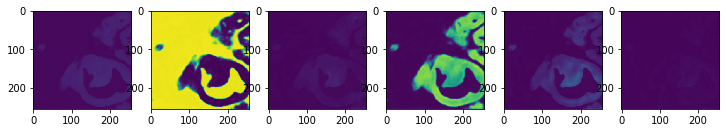

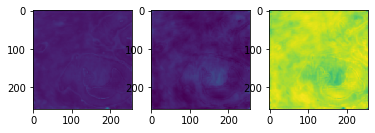

In [296]:
fig, axs = plt.subplots(1, 6, figsize=(12.3, 3.4))
e_mask = o_masks[n, :6].softmax(0).cpu()
vmin, vmax = e_mask.min(), e_mask.max()
for m in range(6):
    axs[m].imshow(e_mask[m].T, vmin=vmin, vmax=vmax);
    
fig, axs = plt.subplots(1, 3, figsize=(6, 3.4))
e_mask = o_masks[n, -3:].softmax(0).cpu()
vmin, vmax = e_mask.min(), e_mask.max()
for m in range(3):
    axs[m].imshow(e_mask[m].T, vmin=vmin, vmax=vmax);    

In [ ]:
fig, axs = plt.subplots(1, actual_lbl_nums, figsize=(18, 18))
e_mask = masks[n].cpu()
for m in range(actual_lbl_nums):
    axs[m].imshow(e_mask.T == m, vmin=0, vmax=1);

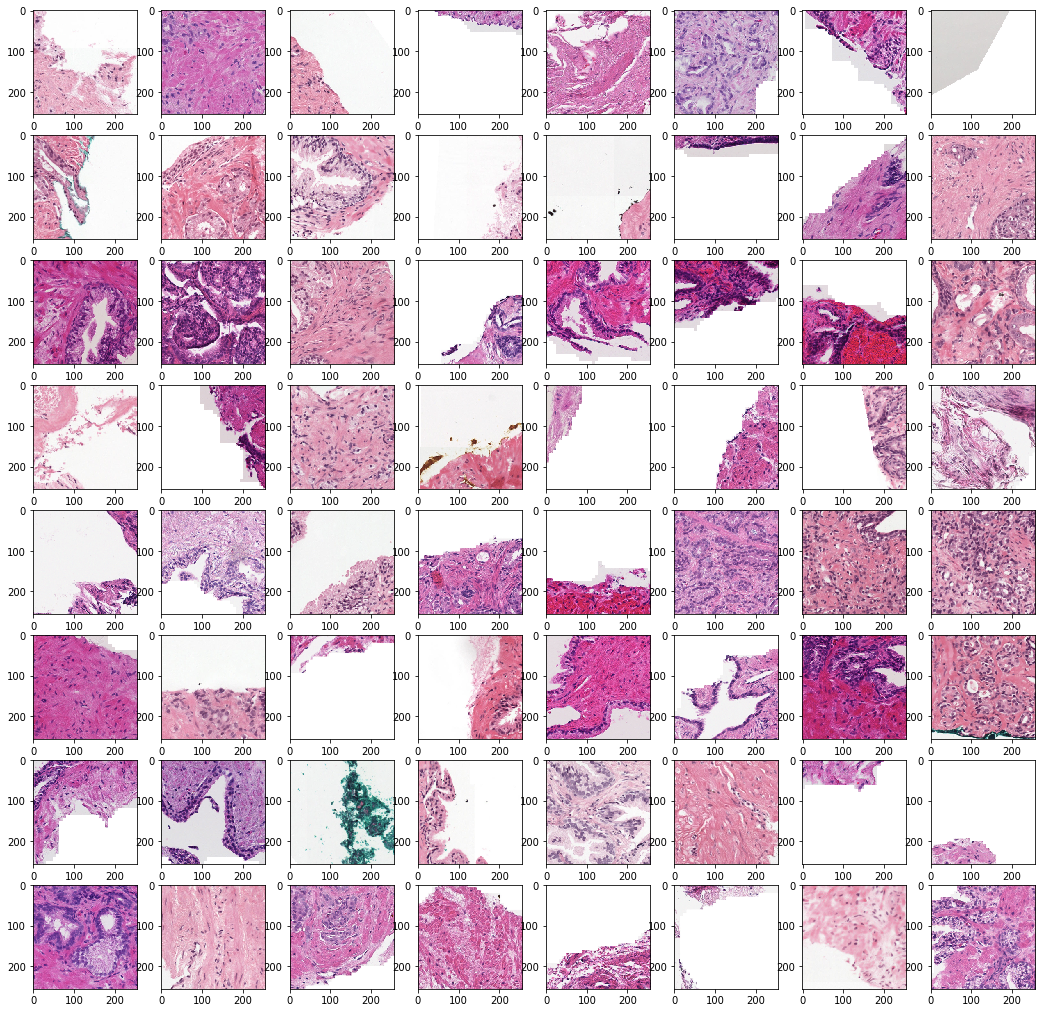

In [22]:
fig, axs = plt.subplots(8, 8, figsize=(18, 18))
axs = axs.ravel()
for n in range(64):
    axs[n].imshow(imgs[n].cpu().transpose(0, -1));